# Field inference for multiple dipole sources

We have shown (`potentials.ipynb`) that it is possible to learn analytical forms like the dipole field with acceptable accuracy through a variety of routes including the scalar and vector potentials. In this demonstration, we want to model the potential/field from multiple fixed sources at arbitrary field points, and to do so while running over the sources and inference points separately; i.e. O(M + N) and not O(M * N).

We suppose this to be possible because of the principle of superposition for potentials / fields, and our implementation separately the input of magnetic sources (the 'priming' network) from the inference ('main' network). In particular, we try learning a hypernetwork where the role of the priming network is to output the weights for the main network. We will use jax, equinox and optax to develop a model combining neural and analytical (autodiff) components.

In [1]:
import jax
import jax.random as jr
import jax.numpy as jnp
import equinox as eqx
import optax
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib.gridspec as gridspec

import scienceplots  # noqa

plt.style.use(["science", "ieee"])

## I. Target definition and data augmentation

We expect the neural components of the model to learn transcendental functions. The dipole field at $\mathbf{r}$ from a collection of point-like sources with moments $\mathbf{m}_i$ and positions $\mathbf{r}_i$ is computed via the scalar potential as $${\mu_0}\mathbf{H}_{\odot}(\mathbf{r}) = -\nabla\sum_{i=1}^N \underbrace{\overbrace{\frac{1}{4\pi |\mathbf{r}-\mathbf{r_i}|^2}}^{\text{Surface of 3D ball}}\overbrace{\frac{\mathbf{m}_i\cdot(\mathbf{r}-\mathbf{r_i})}{|\mathbf{r}-\mathbf{r_i}|}}^{\text{dipole term}}}_{\text{scalar potential }\psi_i}$$. 

A realistic (non-pointlike) source will have the more general form $\mathbf{H}(\mathbf{r}) = - \mathbb{N}(\mathbf{r})\mathbf{M}$ inside the source, and by Gauss' Law $\mathbf{H} \sim \mathbf{H}_\odot$ outside it. The distinguishing feature of the dipole term is the $\sim 1/r$ dependence; higher multipole terms ($1/r^2$, $1/r^3$) might also be included, but the dipole term will quickly dominate at larger $r$. Similarly, the potential in two dimensions is obtained by exchanging the surface area of the 2D ball.

We generate random samples to serve as the training data, precomputing the target potential values. Using a fixed training set helps with the stability of training, but we refresh the validation set each time its accuracy computation is needed. First, we describe the collection of sources.

In [2]:
def scalar_potential(m, r0, r):
    core = 0.5
    d = r - r0
    d_norm = jnp.linalg.norm(d)
    m_dot_r = jnp.dot(m, d)
    close_to_source = d_norm < core
    interior = m_dot_r / core / (2 * jnp.pi * core)
    exterior = m_dot_r / d_norm / (2 * jnp.pi * d_norm)
    return jnp.where(close_to_source, interior, exterior)


def generate_total_potential(m, r0, r):
    points = jax.vmap(scalar_potential, in_axes=(None, None, 0))
    batch = jax.vmap(points, in_axes=(0, 0, None))
    potential = jax.vmap(batch, in_axes=(1, 1, None))(m, r0, r)
    return jnp.sum(potential, axis=0)


def generate_total_field(m, r0, r):
    points = jax.vmap(jax.grad(scalar_potential, argnums=2), in_axes=(None, None, 0))
    batch = jax.vmap(points, in_axes=(0, 0, None))
    potential = jax.vmap(batch, in_axes=(1, 1, None))(m, r0, r)
    return -jnp.sum(potential, axis=0)

In [3]:
def plots(x_grid, y_grid, potential, field, idx=0, prefix=""):
    # Control the font size
    plt.rc("font", size=16)  # controls default text sizes
    plt.rc("axes", titlesize=16)  # fontsize of the axes title
    plt.rc("axes", labelsize=16)  # fontsize of the x and y labels
    plt.rc("xtick", labelsize=16)  # fontsize of the tick labels
    plt.rc("ytick", labelsize=16)  # fontsize of the tick labels
    plt.rc("legend", fontsize=16)  # legend fontsize
    plt.rc("figure", titlesize=20)  # fontsize of the figure title

    fig = plt.figure(figsize=(12.6, 6))
    gs = gridspec.GridSpec(1, 3, width_ratios=[1, 0.05, 1], wspace=0.075)
    # fig, axes = plt.subplots(1, 2, )
    ax1 = plt.subplot(gs[0])

    # Subplot 1: Magnetic Scalar Potential
    cp = ax1.contourf(x_grid, y_grid, potential[idx])
    # plt.colorbar(cp, ax=axes[0])
    ax1.scatter(r0[idx, :, 0], r0[idx, :, 1], color="red")
    ax1.quiver(
        r0[idx, :, 0],
        r0[idx, :, 1],
        m[idx, :, 0],
        m[idx, :, 1],
        angles="xy",
        scale_units="xy",
        scale=1,
        color="red",
    )
    units_str = ", in units of source radius"
    ax1.set_title(prefix + " " + "Magnetic Scalar Potential")
    ax1.set_xlabel("$x$" + units_str)
    ax1.set_ylabel("$y$" + units_str)

    # Subplot 2: Magnetic Field
    ax2a = plt.subplot(gs[2])
    ax2 = ax2a.twinx()
    ax2.streamplot(
        x_grid,
        y_grid,
        field[idx, :, :, 0],
        field[idx, :, :, 1],
        density=1.5,
        linewidth=1,
        arrowsize=1.5,
        arrowstyle="->",
    )
    ax2.scatter(r0[idx, :, 0], r0[idx, :, 1], color="red")
    ax2.quiver(
        r0[idx, :, 0],
        r0[idx, :, 1],
        m[idx, :, 0],
        m[idx, :, 1],
        angles="xy",
        scale_units="xy",
        scale=1,
        color="red",
    )
    ax2.set_title(prefix + " " + "Magnetic Field")
    ax2a.set_xlabel("$x$" + units_str)
    ax2.set_ylabel("$y$" + units_str)
    ax2a.set_yticklabels([])

    cbar_ax = plt.subplot(gs[1])
    cbar = plt.colorbar(cp, cax=cbar_ax)

    pos1 = cbar_ax.get_position()  # Get the original position of ax1
    cbar_ax.set_position([pos1.x0 - 0.0075, pos1.y0, pos1.width, pos1.height])

    # Get current ticks and labels
    ticks = cbar.get_ticks()
    tick_labels = cbar.ax.get_yticklabels()

    # Filter to keep every second tick and label
    filtered_ticks = ticks[1::2]
    filtered_tick_labels = [
        label.get_text() for i, label in enumerate(tick_labels) if i % 2 == 1
    ]

    # Set the filtered ticks and their labels, with rotation
    cbar.set_ticks(filtered_ticks)
    cbar.ax.set_yticklabels(
        filtered_tick_labels, rotation=90, va="center", fontdict={"fontsize": 12}
    )
    # plt.tight_layout()
    plt.show()

In [4]:
M = 3
N = 1
key, subkey = jr.split(jr.PRNGKey(342 - 1), 2)
m, r0 = jnp.split(jr.normal(key=subkey, shape=(N, M, 4)), 2, axis=-1)

In [5]:
lim, res = 3, 50
x_grid, y_grid = np.meshgrid(np.linspace(-lim, lim, res), np.linspace(-lim, lim, res))
flat_grid = np.stack([x_grid.flatten(), y_grid.flatten()], axis=1)
potential = generate_total_potential(m, r0, flat_grid)
field = generate_total_field(m, r0, flat_grid)

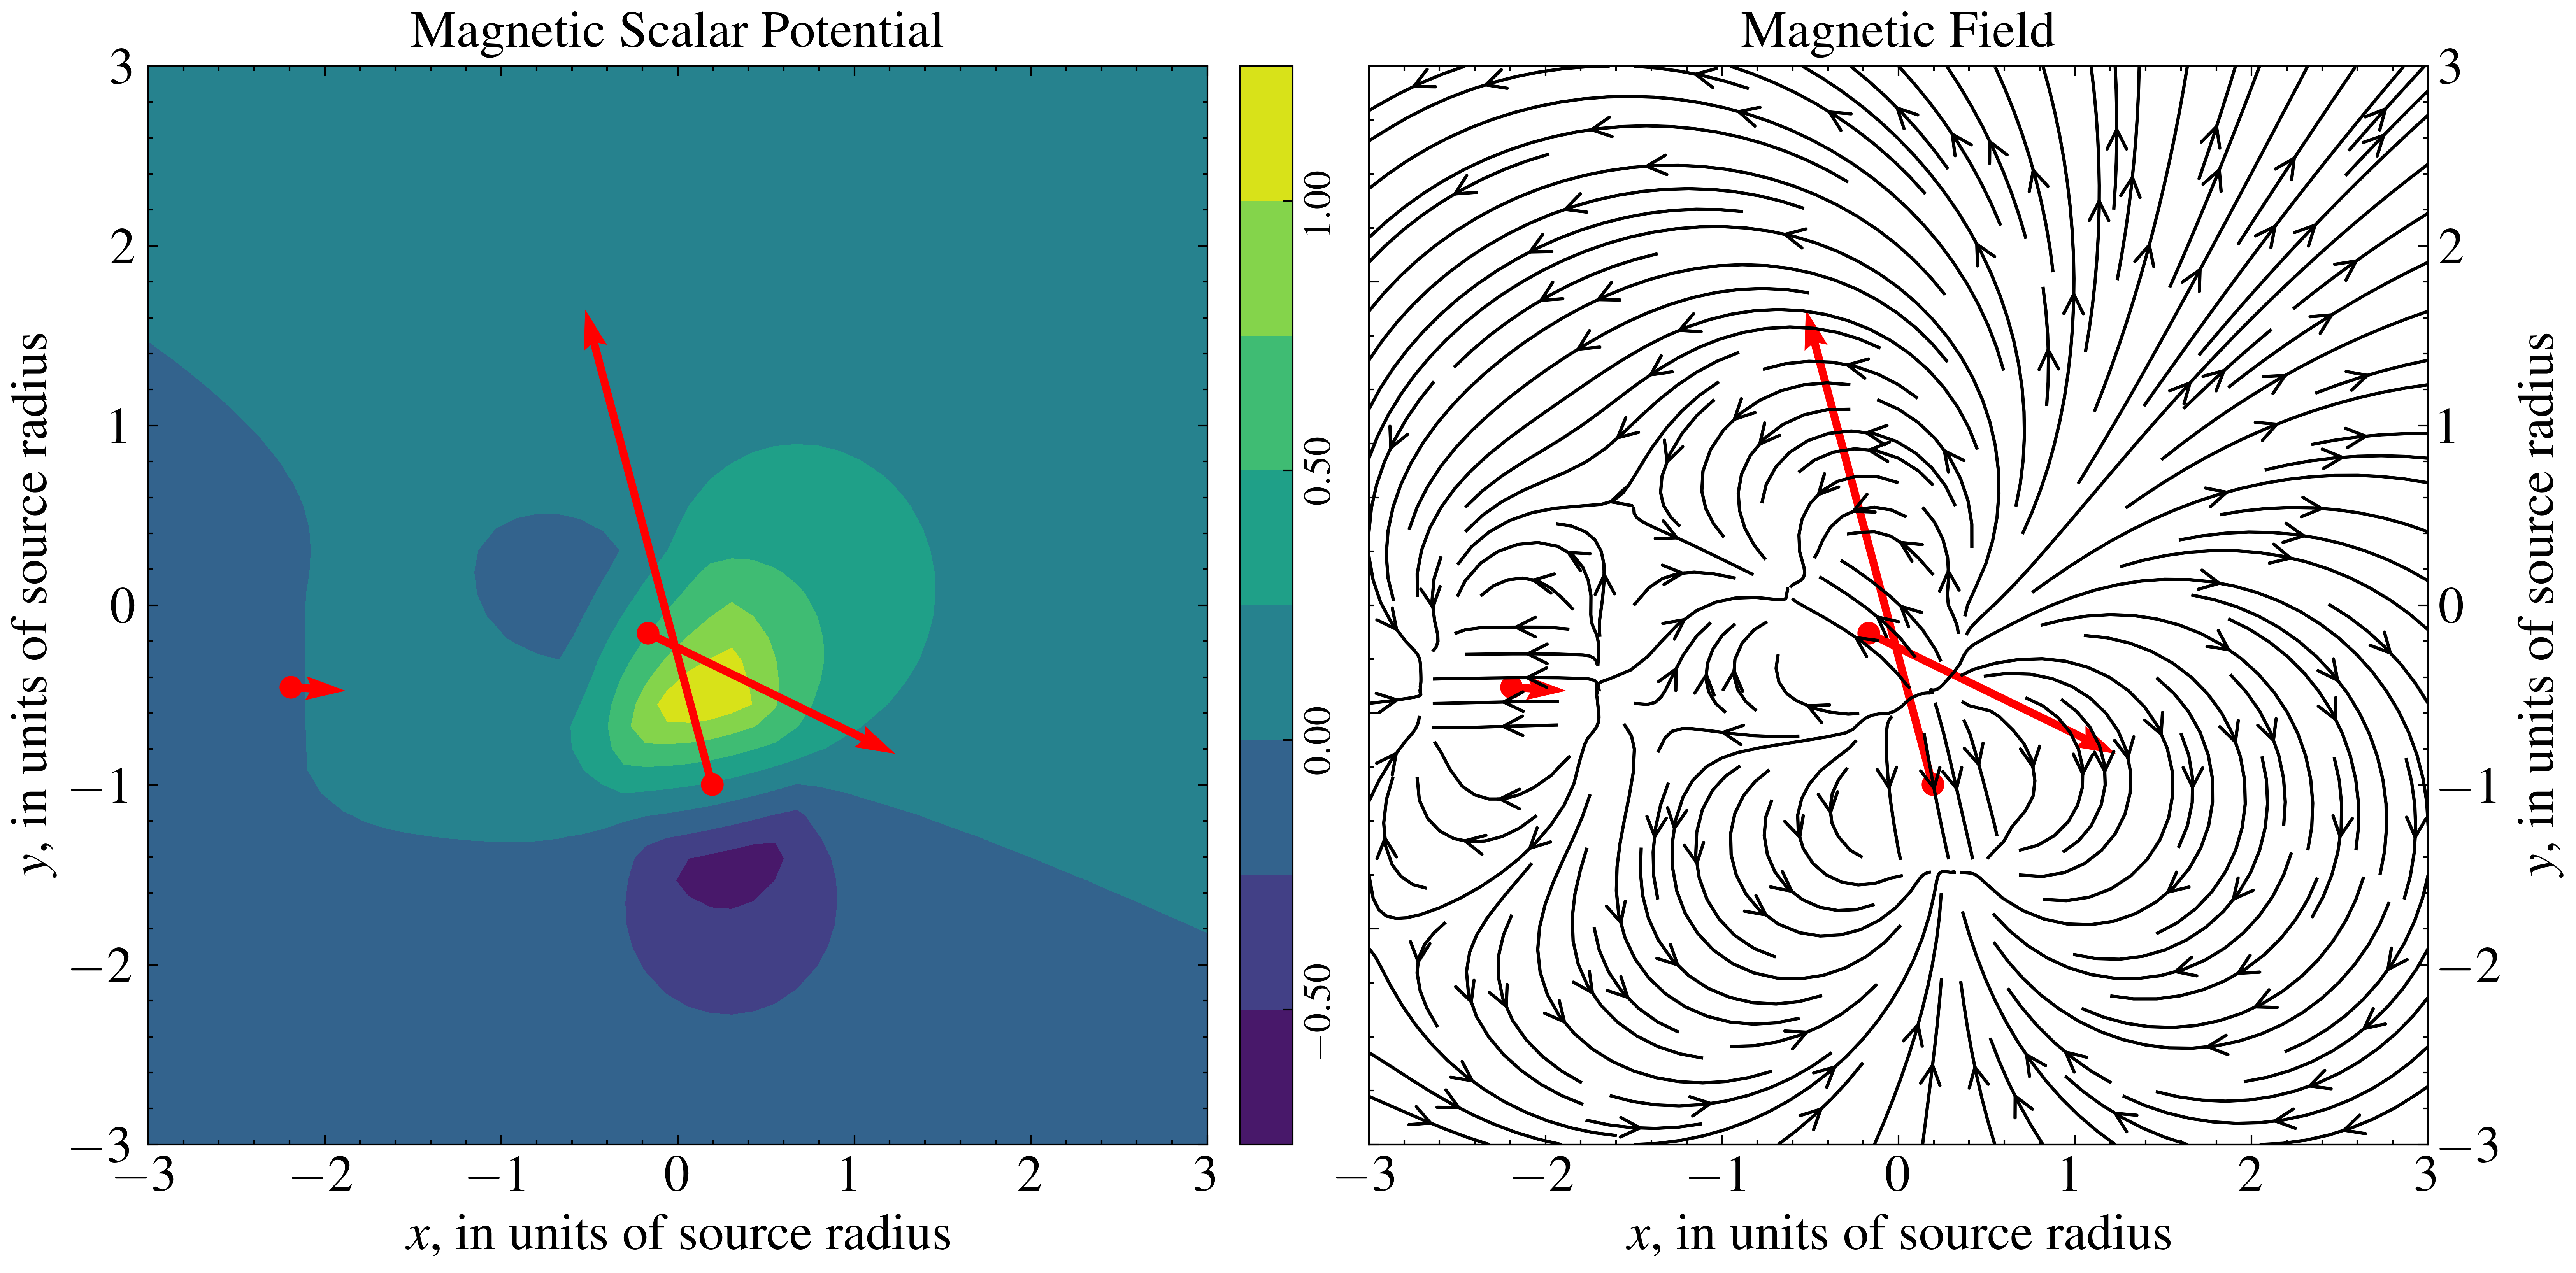

In [6]:
plots(
    x_grid,
    y_grid,
    potential.reshape(N, res, res),
    field.reshape(N, res, res, 2),
    idx=0,
)

## II. Inference

To start with, let's show that we can model the potential for this static source configuration, generalising to new field points without making any attempt at learning how the sources influence it. The grid points and evaluations we've used for plotting above are ready to be used as training data. We train an MLP network of fixed size to learn $\mu_0 \mathbf{H}$, using the relative geometric error as the target measure of accuracy. 

In [7]:
@eqx.filter_jit
def loss(model, r, target):
    pred = jax.vmap(model)(r)
    return jnp.mean(optax.huber_loss(pred, target))


@eqx.filter_jit
def accuracy(model, r, target):
    pred = jax.vmap(model)(r)
    diff = jnp.abs(target - pred)
    return diff / jnp.abs(target) * 100


@eqx.filter_jit
def accuracy_field(model, r, target):
    pred = -jax.vmap(jax.grad(model))(r)
    diff = jnp.linalg.norm(target - pred, axis=-1)
    return diff / jnp.linalg.norm(target, axis=-1) * 100

The training loop for the model, using the Adam optimiser and using batch (i.e. full batch) training, and logging the accuracy 100 times during the run of 10,000 epochs.

In [10]:
@eqx.filter_jit
def train_step(model, opt_state, r, y):
    loss_value, grads = eqx.filter_value_and_grad(loss)(model, r, y)
    updates, opt_state = optim.update(grads, opt_state, model)
    model = eqx.apply_updates(model, updates)
    return model, opt_state, loss_value


@eqx.filter_jit
def validation_set(model, subkey, size=10_000):
    mesh = jr.uniform(minval=-lim, maxval=lim, shape=(size, 2), key=subkey)
    potential = generate_total_potential(m, r0, mesh)
    field = generate_total_field(m, r0, mesh)
    return jnp.median(accuracy(model, mesh, potential)), jnp.median(
        accuracy_field(model, mesh, field)
    )


key, subkey = jr.split(key, 2)

steps = 200_000
runs = 5
logger_potential = []

for run in range(runs):
    model = eqx.nn.MLP(
        in_size=2,
        out_size="scalar",
        width_size=32,
        depth=3,
        activation=jax.nn.gelu,
        use_bias=True,
        use_final_bias=False,
        key=subkey + run,
    )

    optim = optax.adam(learning_rate=5e-5, b1=0.95)
    opt_state = optim.init(eqx.filter(model, eqx.is_array))

    logger_potential.append(
        {
            "train_loss": [],
            "train_acc": [],
            "val_acc": [],
            "val_acc_field": [],
        }
    )
    for step in range(steps):
        model, opt_state, train_loss = train_step(
            model, opt_state, flat_grid, potential
        )
        if (step % (steps / 100)) == 0:
            logger_potential[run]["train_loss"].append(train_loss)
            logger_potential[run]["train_acc"].append(
                jnp.median(accuracy(model, flat_grid, potential))
            )

            # Generate validation data
            key, subkey = jr.split(key, 2)
            val_acc, val_acc_field = validation_set(model, subkey)
            logger_potential[run]["val_acc"].append(val_acc)
            logger_potential[run]["val_acc_field"].append(val_acc_field)
        if (step % (steps / 10)) == 0:
            print(
                f"{run=}, {step=}, train_loss={train_loss:.4f}, ",
                f"accuracy={logger_potential[run]['train_acc'][-1]:.4f}",
                f"val_accuracy={logger_potential[run]['val_acc'][-1]:.4f}",
                f"val_accuracy_field={logger_potential[run]['val_acc_field'][-1]:.4f}",
            )

    key, subkey = jr.split(key, 2)
    rge, _ = validation_set(model, subkey)
    print(f"Final accuracy: {rge:.2f}%")

run=0, step=0, train_loss=0.0181,  accuracy=97.7175 val_accuracy=97.7758 val_accuracy_field=100.0067
run=0, step=20000, train_loss=0.0000,  accuracy=1.0759 val_accuracy=1.0315 val_accuracy_field=9.1461
run=0, step=40000, train_loss=0.0000,  accuracy=0.5238 val_accuracy=0.5106 val_accuracy_field=5.1246
run=0, step=60000, train_loss=0.0000,  accuracy=0.4797 val_accuracy=0.4666 val_accuracy_field=4.8802
run=0, step=80000, train_loss=0.0000,  accuracy=0.3903 val_accuracy=0.3789 val_accuracy_field=4.1571
run=0, step=100000, train_loss=0.0000,  accuracy=0.3785 val_accuracy=0.3822 val_accuracy_field=4.3263
run=0, step=120000, train_loss=0.0000,  accuracy=0.3567 val_accuracy=0.3653 val_accuracy_field=4.0960
run=0, step=140000, train_loss=0.0000,  accuracy=0.3273 val_accuracy=0.3329 val_accuracy_field=4.0022
run=0, step=160000, train_loss=0.0000,  accuracy=0.2949 val_accuracy=0.3013 val_accuracy_field=3.6734
run=0, step=180000, train_loss=0.0000,  accuracy=0.2819 val_accuracy=0.2904 val_accurac

In [ ]:
val_mesh = jr.uniform(minval=-lim, maxval=lim, shape=(10_000, 2), key=subkey)
val_potential = generate_total_potential(m, r0, val_mesh)
val_field = generate_total_field(m, r0, val_mesh)
print(jnp.median(accuracy(model, val_mesh, val_potential)))
print(jnp.median(accuracy_field(model, val_mesh, val_field)))

## IIb. Evaluate magnetic field directly from model

In [13]:
@eqx.filter_jit
def loss(model, r, target):
    pred = jax.vmap(model)(r)
    return jnp.mean(optax.huber_loss(pred, target))


@eqx.filter_jit
def accuracy_field(model, r, target):
    pred = jax.vmap(model)(r)
    diff = jnp.linalg.norm(target - pred, axis=-1)
    return diff / jnp.linalg.norm(target, axis=-1) * 100

In [ ]:
print(loss(model_field, flat_grid, field))

In [15]:
@eqx.filter_jit
def train_step(model, opt_state, r, y):
    loss_value, grads = eqx.filter_value_and_grad(loss)(model, r, y)
    updates, opt_state = optim.update(grads, opt_state, model)
    model = eqx.apply_updates(model, updates)
    return model, opt_state, loss_value


@eqx.filter_jit
def validation_set(model, subkey, size=10_000):
    mesh = jr.uniform(minval=-lim, maxval=lim, shape=(size, 2), key=subkey)
    field = generate_total_field(m, r0, mesh)
    return jnp.median(accuracy_field(model, mesh, field))


key, subkey = jr.split(key, 2)


steps = 200_000
runs = 5
logger = []

for run in range(runs):
    model_field = eqx.nn.MLP(
        in_size=2,
        out_size=2,
        width_size=32,
        depth=3,
        activation=jax.nn.gelu,
        use_bias=True,
        use_final_bias=False,
        key=subkey + run,
    )

    optim = optax.adam(learning_rate=5e-5, b1=0.95)
    opt_state = optim.init(eqx.filter(model_field, eqx.is_array))

    logger.append({"train_loss": [], "train_acc": [], "val_acc": []})
    for step in range(steps):
        model_field, opt_state, train_loss = train_step(
            model_field, opt_state, flat_grid, field
        )
        if (step % (steps / 100)) == 0:
            logger[run]["train_loss"].append(train_loss)
            logger[run]["train_acc"].append(
                jnp.median(accuracy_field(model_field, flat_grid, field))
            )

            # Generate validation data
            key, subkey = jr.split(key, 2)
            logger[run]["val_acc"].append(validation_set(model_field, subkey))
        if (step % (steps / 10)) == 0:
            print(
                f"{run=}, {step=}, train_loss={train_loss:.4f}, ",
                f"accuracy={logger[run]['train_acc'][-1]:.4f}",
                f"val_accuracy={logger[run]['val_acc'][-1]:.4f}",
            )

    key, subkey = jr.split(key, 2)
    rge = validation_set(model_field, subkey)
    print(f"Final accuracy: {rge:.2f}%")

step=0, train_loss=0.0447,  accuracy=108.5718 val_accuracy=107.4116
step=20000, train_loss=0.0003,  accuracy=13.8764 val_accuracy=13.7169
step=40000, train_loss=0.0001,  accuracy=7.6771 val_accuracy=7.8855
step=60000, train_loss=0.0001,  accuracy=6.1605 val_accuracy=6.3339
step=80000, train_loss=0.0001,  accuracy=5.5800 val_accuracy=5.8912
step=100000, train_loss=0.0000,  accuracy=5.3334 val_accuracy=5.6776
step=120000, train_loss=0.0000,  accuracy=4.7435 val_accuracy=5.0550
step=140000, train_loss=0.0000,  accuracy=4.3124 val_accuracy=4.7088
step=160000, train_loss=0.0000,  accuracy=3.9839 val_accuracy=4.5198
step=180000, train_loss=0.0000,  accuracy=3.8059 val_accuracy=4.2522
Final accuracy: 4.16%
step=0, train_loss=0.0451,  accuracy=125.2889 val_accuracy=121.9703
step=20000, train_loss=0.0003,  accuracy=13.8364 val_accuracy=13.8773
step=40000, train_loss=0.0001,  accuracy=8.2550 val_accuracy=8.3410
step=60000, train_loss=0.0001,  accuracy=6.2433 val_accuracy=6.4820
step=80000, train

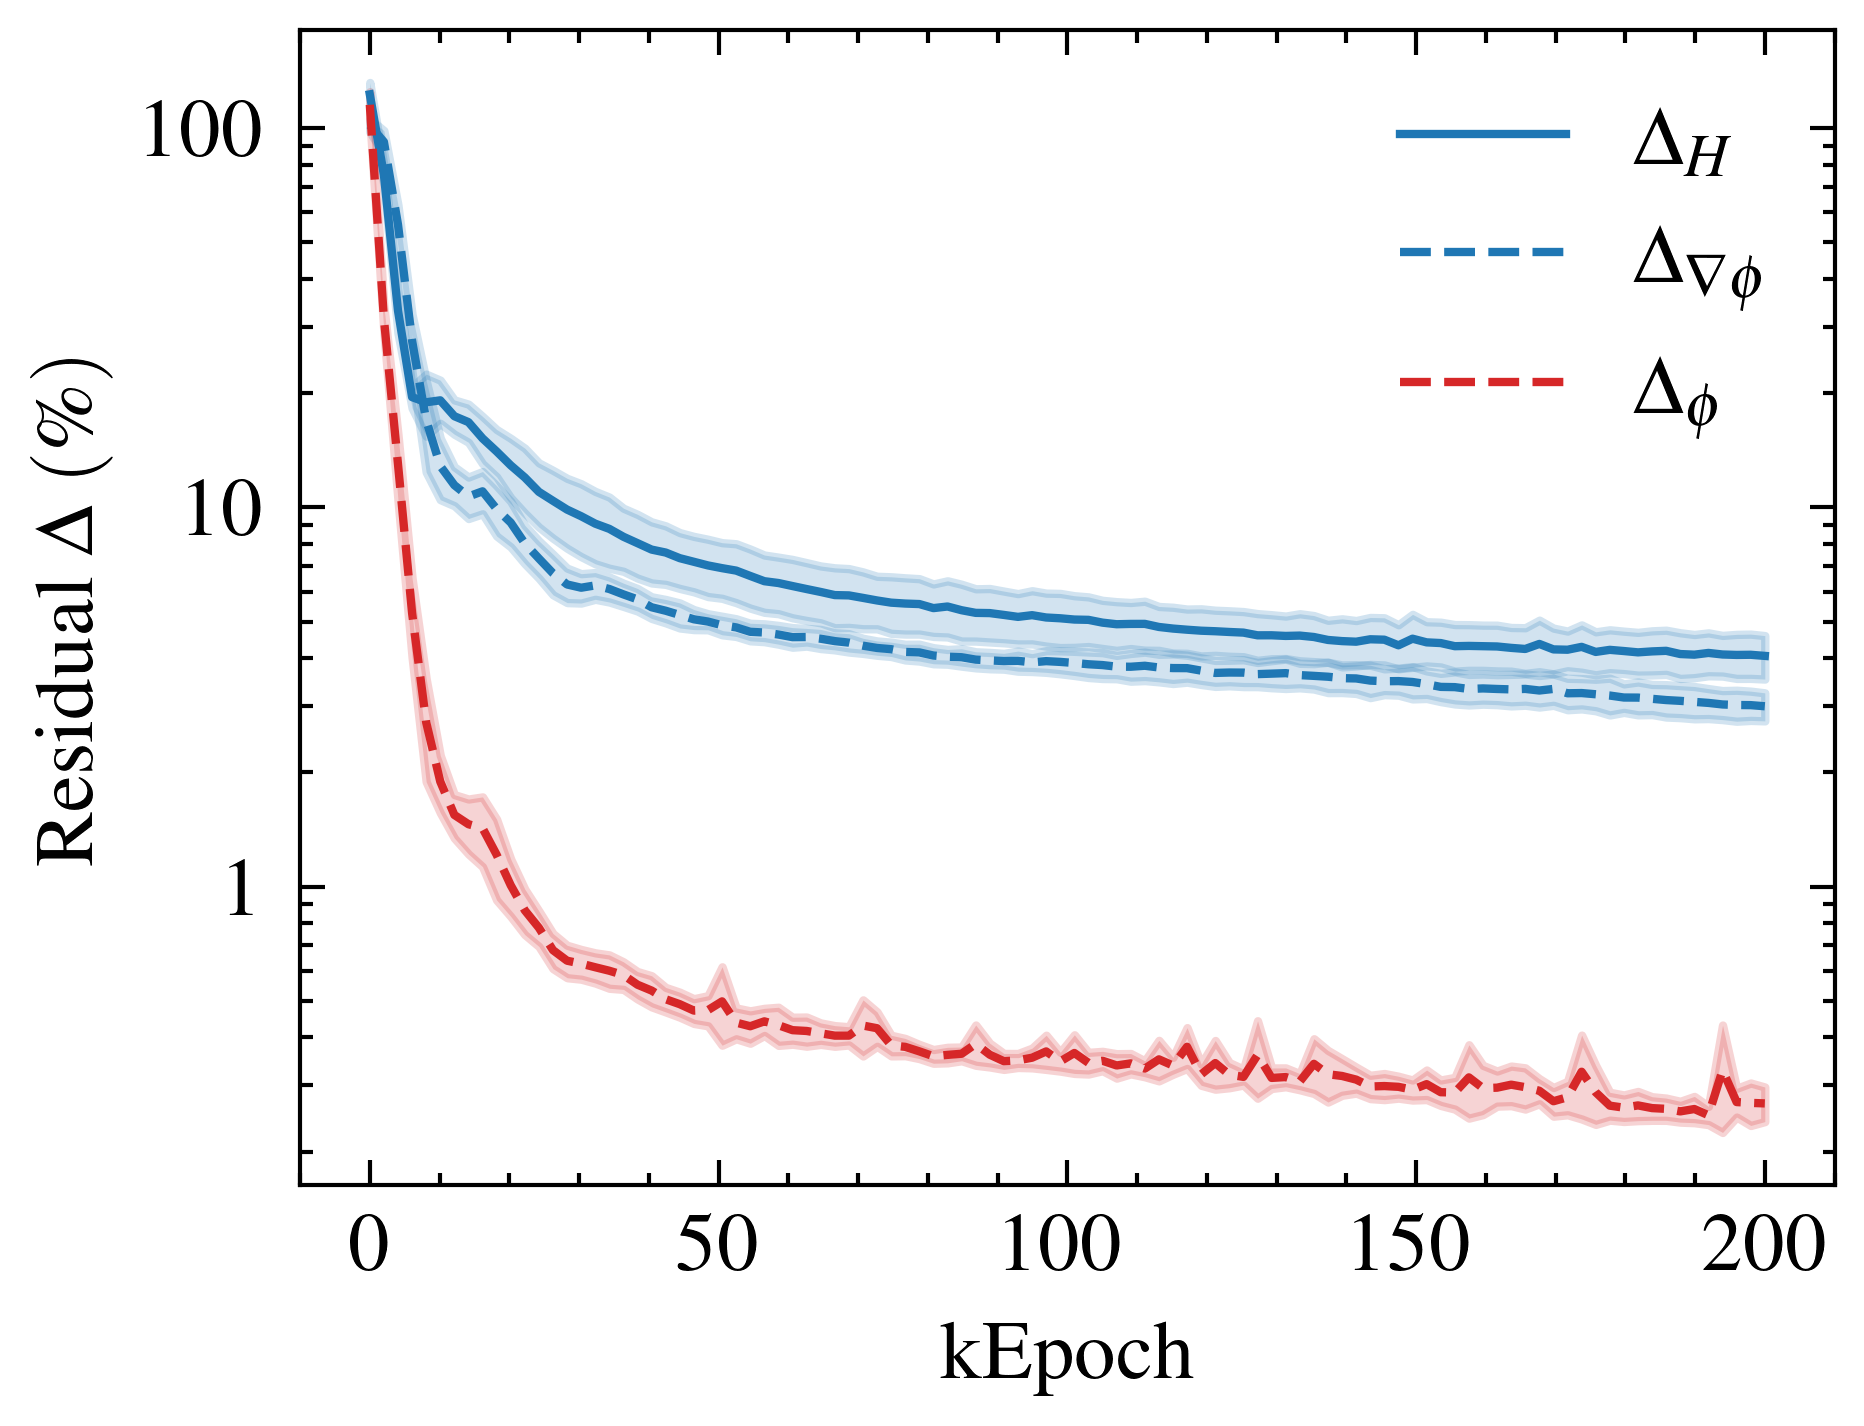

In [20]:
# # Control the font size
plt.rc("font", size=12)  # controls default text sizes
plt.rc("axes", titlesize=12)  # fontsize of the axes title
plt.rc("axes", labelsize=10)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=10)  # fontsize of the tick labels
plt.rc("ytick", labelsize=10)  # fontsize of the tick labels
plt.rc("legend", fontsize=10)  # legend fontsize
plt.rc("figure", titlesize=12)  # fontsize of the figure title

plt.style.use(["science", "ieee"])

num_runs = len(logger_potential)
epochs = jnp.linspace(0, 200, 100)
delta_phi_all_runs = np.zeros((num_runs, len(epochs)))
delta_H2_all_runs = np.zeros((num_runs, len(epochs)))
delta_H1_all_runs = np.zeros((num_runs, len(epochs)))
for idx in range(num_runs):
    delta_H1_all_runs[idx, :] = logger[idx]["val_acc"]
    delta_phi_all_runs[idx, :] = logger_potential[idx]["val_acc"]
    delta_H2_all_runs[idx, :] = logger_potential[idx]["val_acc_field"]

delta_H1 = np.mean(delta_H1_all_runs, axis=0)
delta_H2 = np.mean(delta_H2_all_runs, axis=0)
delta_phi = np.mean(delta_phi_all_runs, axis=0)

std_delta_H1 = np.std(delta_H1_all_runs, axis=0)
std_delta_H2 = np.std(delta_H2_all_runs, axis=0)
std_delta_phi = np.std(delta_phi_all_runs, axis=0)


# Function to format the y-axis labels
def format_func(value, tick_number):
    return f"{int(value)}"


# Creating the figure and the first axis
fig, ax1 = plt.subplots()

# Plotting the Delta_H curves on the first (left) axis
(line1,) = ax1.semilogy(epochs, delta_H1, label="$\Delta_H$", color="tab:blue")
ax1.fill_between(
    epochs,
    delta_H1 - std_delta_H1,
    delta_H1 + std_delta_H1,
    color="tab:blue",
    alpha=0.2,
)

(line2,) = ax1.semilogy(
    epochs, delta_H2, label="$\Delta_{\\nabla\phi}$", color="tab:blue", linestyle="--"
)
ax1.fill_between(
    epochs,
    delta_H2 - std_delta_H2,
    delta_H2 + std_delta_H2,
    color="tab:blue",
    alpha=0.2,
)

# Creating the second axis, sharing the same x-axis as ax1
# ax2 = ax1.twinx()

# Plotting the Delta_phi curve on the second (right) axis
(line3,) = ax1.semilogy(
    epochs, delta_phi, label="$\Delta_{\phi}$", color="tab:red", linestyle="--"
)
ax1.fill_between(
    epochs,
    delta_phi - std_delta_phi,
    delta_phi + std_delta_phi,
    color="tab:red",
    alpha=0.2,
)

# Setting the y-axis formatter
ax1.yaxis.set_major_formatter(FuncFormatter(format_func))
ax1.yaxis.set_major_formatter(FuncFormatter(format_func))

# Labels, title, and legend
ax1.set_xlabel("kEpoch")
ax1.set_ylabel("Residual $\Delta\ (\%)$")
# ax1.set_ylabel("$\Delta_H, \Delta_{\\nabla\phi} (\%)$", color="tab:blue")
# ax2.set_ylabel("$\Delta_{\phi} (\%)$", color="tab:red")
ax1.tick_params(axis="y")  # , colors="tab:blue")
# ax2.tick_params(axis="y", colors="tab:red")

# Combining legends from both axes
lines = [line1, line2, line3]
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc="upper right")

plt.show()